## Evade Signal Classification with FGSM

This notebook shows the performance of a digital FGSM attack on an Automatic Modulation Classification neural network model.

### Assumptions
- The dataset wrangling has already been completed (and is provided here)
- The implementation of model training on this dataset has already been completed
- The plotting code has already been completed

### Components Recreated in Tutorial
- FGSM attack constrained by a power ratio

### See Also
The code in this tutorial is a stripped down version of the code in ``rfml.attack.fgsm`` that simplifies discussion.  Further detail can be provided by directly browsing the source files.

### Install the library code and dependencies

In [1]:
# Install the library code
#!pip install git+https://github.com/brysef/rfml.git@1.0

In [2]:
# Ensure that the least loaded GPU is used
import setGPU

# Plotting Includes
import matplotlib.pyplot as plt

# External Includes
import numpy as np

import torch
from torch.nn.functional import cross_entropy
from torch.utils.data import DataLoader, TensorDataset

# Internal Includes
from rfml.data import Dataset, Encoder
from rfml.data import build_dataset

from rfml.nbutils import plot_acc_vs_spr, plot_confusion

from rfml.nn.eval import compute_accuracy
from rfml.nn.eval.confusion import _confusion_matrix
from rfml.nn.F import energy
from rfml.nn.model import build_model
from rfml.nn.train import build_trainer, PrintingTrainingListener

setGPU: Setting GPU to: 1


### Configuration

In [3]:
gpu = True       # Set to True to use a GPU for training
fig_dir = None   # Set to a file path if you'd like to save the plots generated
data_path = None # Set to a file path if you've downloaded RML2016.10A locally

## Train and Evaluate a Model on a Static Dataset

See ``module_2`` for a more extensive description of this procedure.
Here we just use the library for a quick implementation.
In practice, the model training would be separated from the attack, but, is juxtaposed with the attack here for simplicity as it is self-contained for demonstration.

In [4]:
train, test, val, le = build_dataset("RML2016.10a", path=data_path)
# as_numpy returns x,y and x is shape BxCxIQxN
input_samples = val.as_numpy(le=le)[0].shape[3]
model = build_model(model_name="CNN", input_samples=input_samples, n_classes=len(le))
trainer = build_trainer(strategy="standard", max_epochs=3, gpu=gpu)
trainer.register_listener(PrintingTrainingListener())
trainer(model=model, training=train, validation=val, le=le)
acc = compute_accuracy(model=model, data=test, le=le)

print("Overall Testing Accuracy: {:.4f}".format(acc))

Epoch 0 completed!
		-Mean Training Loss: 1.383
		-Mean Validation Loss: 1.201
Epoch 1 completed!
		-Mean Training Loss: 1.189
		-Mean Validation Loss: 1.115
Epoch 2 completed!
		-Mean Training Loss: 1.133
		-Mean Validation Loss: 1.062
Training has Completed:

	Best Validation Loss: 1.062
	Best Epoch: 2
	Total Epochs: 2
Overall Testing Accuracy: 0.5576


### Strip Down the Testing Data
Strip the data down to only the highest SNR (18 dB in RML2016.10a).  This ensures that the classification accuracy would have been close to the highest and gives the best evaluation of the attack because it separates the decreased accuracy from being causes by low SNR vs being caused by the attack.

In [5]:
mask = test.df["SNR"] >= 18
dl = DataLoader(test.as_torch(le=le, mask=mask), shuffle=True, batch_size=512)

### Evading Signal Classification with Direct Access to the Classifier

Here, we're simply going to sweep the **intensity** of the attack, denoted in this tutorial as $E_s/E_p$ or signal-to-perturbation ratio represented in dB.

Recall that the equation for FGSM [Goodfellow et. al] is

\begin{equation}
    x^* = x + \text{sign}(\nabla_X \mathcal{L}(f(\theta, X), y_s))
\end{equation}

For the purposes of a clean implementation in software, we can split this equation into multiple steps.
First, we must compute the *signed gradient*.

\begin{equation}
    \text{"signed gradient"} = \text{sign}(\nabla_X \mathcal{L}(f(\theta, X), y_s))
\end{equation}

This is done by utilizing the model and PyTorch to backpropogate the gradient to the input.
Once the gradient is known, we can apply a simple sign operation.

Then, the signed gradient must be scaled to achieve an allowed intensity.
Traditionally, CV literature uses a norm to constrain the perturbation (e.g. $\left\lVert {x - x^*} \right\rVert_p < \epsilon$).
In the context of wireless communications, it makes more sense to constrain the power ratio of the perturbation to the underlying signal as the absolute values of either the perturbation or signal generally do not matter.
Recall that we've assumed $E_s$ is $1$ and therefore can scale the perturbation using the following equation [Flowers et. al, Sadeghi/Larson].

\begin{equation}
    p = \sqrt{\frac{10^{\frac{-E_s/E_p}{10}}}{2 \times \text{sps}}} \times \text{"signed gradient"}
\end{equation}

Because the RML2016.10A dataset is not properly normalized for all examples, especially AM-SSB, we have to normalize the input data before running the attack to have a known power -- this is the only way to ensure that the attack intensity is correct.

To complete the FGSM algorithm we simply need to add the perturbation to the original example.

\begin{equation}
    \text{"adversarial example"} = x + p
\end{equation}

#### Citations

##### Goodfellow et al

Goodfellow, I., Shlens, J., and Szegedy, C. (2015).  Explaining and harnessing adversarial examples. In Int. Conf. on Learning Representations.

##### Flowers et al

Flowers, B., Buehrer,  R.  M.,  and Headley,  W. C. (2019). Evaluating adversarial evasion attacks in the context of wireless communications. IEEE Transactions on Information Forensics and Security, pages 1–1.

##### Sadeghi/Larson

Sadeghi, M. and Larsson, E. G. (2018). Adversarial attacks on deep-learning based radio signal classification.IEEEWireless Commun. Letters, pages 1–1.

#### Helper methods for the attack

In [6]:
def fgsm(x, y, input_size, net, spr, sps):
    p = compute_signed_gradient(x=x, y=y, input_size=input_size, net=net)
    p = scale_perturbation(sg=p, spr=spr, sps=sps)
    
    return x + p


def compute_signed_gradient(x, y, input_size, net):
    # Ensure that the gradient is tracked at the input, add some noise to avoid any
    # actual zeros in the signal (dithering), and then ensure its the proper shape
    x.requires_grad = True
    _x = _dither(x)

    # Put the inputs/outputs onto the most probable device that the model is currently
    # on -- this could fail if the model gets split amongst multiple devies, but, that
    # doesn't happen in this code.
    _x = _x.to(net.device)
    y = y.to(net.device)

    # Perform forward/backward pass to get the gradient at the input
    _y = net(_x)
    loss = cross_entropy(_y, y)
    loss.backward()

    # Take the sign of the gradient that can be scaled later
    ret = torch.sign(x.grad.data)

    return ret


def scale_perturbation(sg, spr, sps):
    if spr == np.inf:
        return sg * 0
    multiplier = pow(10, -spr / 10.0)
    multiplier = multiplier / (2 * sps)
    multiplier = pow(multiplier, 0.5)

    return sg * multiplier


def _dither(x):
    snr = 100
    voltage = pow(pow(10.0, -snr / 10.0), 0.5)

    noise = x.data.new(x.size()).normal_(0.0, voltage)
    return x + noise


def _normalize(x):
    power = energy(x)
    # Make the dimensions match because broadcasting is too magical to
    # understand in its entirety... essentially want to ensure that we
    # divide each channel of each example by the sqrt of the power of
    # that channel/example pair
    power = power.view([power.size()[0], power.size()[1], 1, 1])

    return x / torch.sqrt(power)


def _sanity_check(desired_spr, adv_x, x):
    signal_power = energy(x)
    perturbation_power = energy(adv_x - x)
    _spr = 10*torch.log10(signal_power / perturbation_power)
    _spr = _spr.detach().numpy().mean()
    if np.abs(_spr - desired_spr) > 0.5:
        raise RuntimeError("Calculated SPR and desired SPR does not match: "
                           "Desired SPR={:0.2f}dB, Calculated SPR={:0.2f}dB, "
                           "Signal Power={:0.2f}dB, Perturbation Power={:0.2f}dB".format(
                               desired_spr,
                               _spr,
                               10.0*np.log10(signal_power.detach().numpy().mean()),
                               10.0*np.log10(perturbation_power.detach().numpy().mean()))
                          )

#### Top Level control loop for the attack

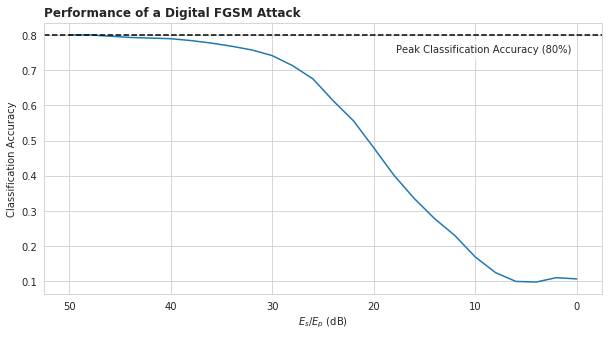

In [7]:
# Ensure that the model is in "evaluation" mode
# -- Therefore batch normalization is not computed and dropout is not performed
# -- Note: This is the cause of a lot of bugs
model.eval()

acc_vs_spr = list()
sprs = list()

for spr in np.linspace(50.0, 0.0, num=26):
    right = 0
    total = 0
    
    for x, y in dl:
        # Before crafting an attack on X, ensure that it is normalized to have a
        # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
        # which will cause the attack intensity to be incorrect.
        x = _normalize(x)
        adv_x = fgsm(x, y, spr=spr, input_size=input_samples, sps=1, net=model)
        
        # Ensure that we've accurately represented the attack power
        _sanity_check(desired_spr=spr, adv_x=adv_x, x=x)
        
        predictions = model.predict(adv_x)
        right += (predictions == y).sum().item()
        total += len(y)

    acc = float(right) / total
    acc_vs_spr.append(acc)
    sprs.append(spr)

fig = plot_acc_vs_spr(acc_vs_spr=acc_vs_spr,
                      spr=sprs,
                      title="Performance of a Digital FGSM Attack"
                     )
if fig_dir is not None:
    file_path = "{fig_dir}/direct_access_fgsm.pdf".format(fig_dir=fig_dir)
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()

#### Constructing a Confusion Matrix

The model breaks down in a way that generally intuitively makes sense to the expert eye with knowledge of the underlying signal formats.  The analog signals are confused for other analog signals, the PSK/QAM signals are confused for other PSK/QAMs with differing modulation orders, etc.  This behavior was examined more closely for targeted adversarial attacks in [Bair et al.] where it was found that the adversarial distance [Papernot et al.], or put more simply, the adversarial perturbation power required to "transform" 50% of the input examples from a source to target class, could be used in a spectral clustering algorithm to recover the relationships between the signal formats.

##### Bair et al.

Bair, S., Delvecchio, M., Flowers, B., Michaels, A. J., andHeadley, W. C. (2019). On the limitations of targeted adversarial evasion attacks against deep learning enabled modulation recognition. In ACM Workshop on Wireless Security and Machine Learning (WiseML 2019).

#### Papernot et al.

Papernot,  N.,  McDaniel,  P.,  Jha,  S.,  Fredrikson,  M.,Celik,  Z.  B.,  and  Swami,  A.  (2016).   The  limitations  of  deep  learningin  adversarial  settings.   InIEEE  European  Symposium  on  Security  andPrivacy (EuroS&P), pages 372–387. IEEE.

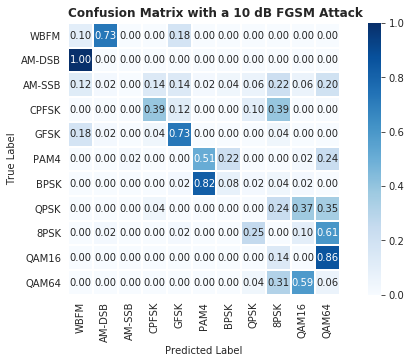

In [8]:
spr = 10  # dB

predictions = list()
labels = list()
for x, y in dl:
    # Before crafting an attack on X, ensure that it is normalized to have a
    # specified power -- RML2016.10a fluctuates a bit, especially on AM-SSB,
    # which will cause the attack intensity to be incorrect.
    x = _normalize(x)
    adv_x = fgsm(x, y, spr=spr, input_size=input_samples, sps=1, net=model)

    # Ensure that we've accurately represented the attack power
    _sanity_check(desired_spr=spr, adv_x=adv_x, x=x)

    _predictions = model.predict(adv_x)
    predictions.extend(_predictions.detach().numpy())
    labels.extend(y)

cmn = _confusion_matrix(predictions=predictions, labels=labels, le=le)

title = "Confusion Matrix with a {spr} dB FGSM Attack".format(spr=spr)
fig = plot_confusion(cm=cmn, labels=le.labels, title=title)
if fig_dir is not None:
    file_path = "{fig_dir}/fgsm_confusion_matrix.pdf"
    print("Saving Figure -> {file_path}".format(file_path=file_path))
    fig.savefig(file_path, format="pdf", transparent=True)
plt.show()